In [2]:
!pip install tensorflow

     -------------------------------------- 438.0/438.0 MB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 12.3 MB/s eta 0:00:00
     -------------------------------------- 895.5/895.5 KB 3.5 MB/s eta 0:00:00
     -------------------------------------- 126.7/126.7 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 65.5/65.5 KB ? eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 7.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 KB 3.0 MB/s eta 0:00:00
     --------------------------------------- 13.9/13.9 MB 11.3 MB/s eta 0:00:00
     -----------------------------

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python310\\Scripts\\wheel.exe' -> 'C:\\Python310\\Scripts\\wheel.exe.deleteme'




     ---------------------------------------- 77.1/77.1 KB 4.5 MB/s eta 0:00:00
     -------------------------------------- 151.5/151.5 KB 8.8 MB/s eta 0:00:00
Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed.
  Running setup.py install for termcolor: started
  Running setup.py install for termcolor: finished with status 'done'


In [3]:
import PIL
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.python.keras import layers
import tensorflow as tf
import time
from IPython import display
%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
#this fixes an error on my machine due to Intel(R) MKL Optimizations
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
tf.__version__

'2.0.0'

### Load dataset

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### The Generator

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

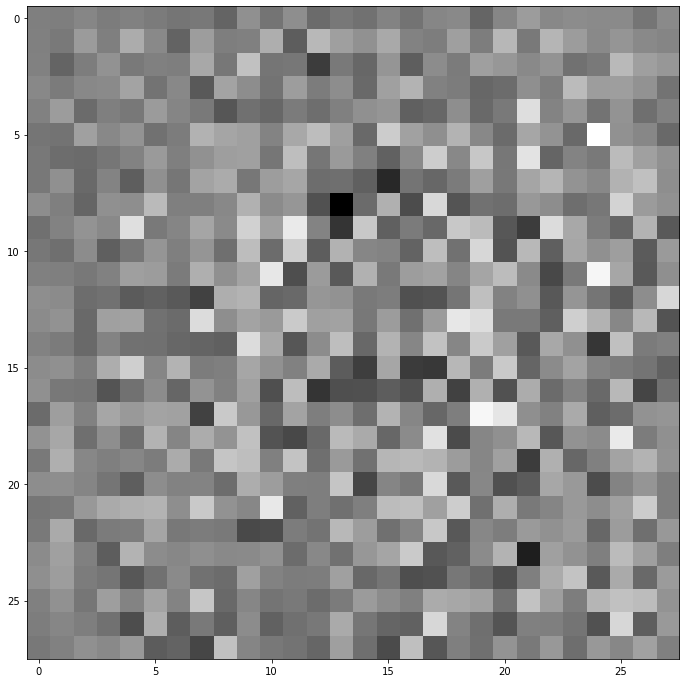

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### The Discriminator

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00134974]], shape=(1, 1), dtype=float32)


In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## Define the loss and optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Functions

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        #produce image
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)
        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

## Train the model

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
